## Simple code to test if torch is correctly installed

In [1]:
import os
import random

import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm



if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Running on GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("Running on CPU")

Running on GPU: NVIDIA GeForce GTX 1060 6GB


### Create simple model

In [2]:

# Define a simple CNN
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.drop2d = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(F.max_pool2d(x, 2))
        x = self.conv2(x)
        x = self.drop2d(x)
        x = F.relu(F.max_pool2d(x, 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

### Download MNIST dataset

In [3]:
# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False)

## Train simple model

In [4]:
# Initialize the network, loss function, and optimizer    
net = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Train the network
num_epochs = 10
for epoch in range(num_epochs):
    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader), total=len(trainloader), ncols=80, leave=False)
    for i, (inputs, labels) in pbar:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        pbar.set_description(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss / (i+1):.4f}")

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss / len(trainloader):.4f}")

# Save Network

torch.save(net.state_dict(), "mnist_model.pth")


  0%|                                                   | 0/600 [00:00<?, ?it/s]/tmp/ipykernel_14176/526990420.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Epoch 1/10, Loss: 2.0691


Epoch 2/10, Loss: 0.9460


Epoch 3/10, Loss: 0.6066


Epoch 4/10, Loss: 0.4857


Epoch 5/10, Loss: 0.4120


Epoch 6/10, Loss: 0.3670


Epoch 7/10, Loss: 0.3377


Epoch 8/10, Loss: 0.3091


Epoch 9/10, Loss: 0.2967


Epoch 10/10, Loss: 0.2719


In [11]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Test the network
state = torch.load("./mnist_model.pth")
model = Net()
model.load_state_dict(state)
model.to(device)
model.eval()

correct = 0
total = 0

with torch.no_grad():

    for data, labels in testloader:
        images, labels = data.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Accuracy on the 10000 test images: {100 * correct / total}%")

/tmp/ipykernel_14176/526990420.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Accuracy on the 10000 test images: 97.16%


/tmp/ipykernel_14176/526990420.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


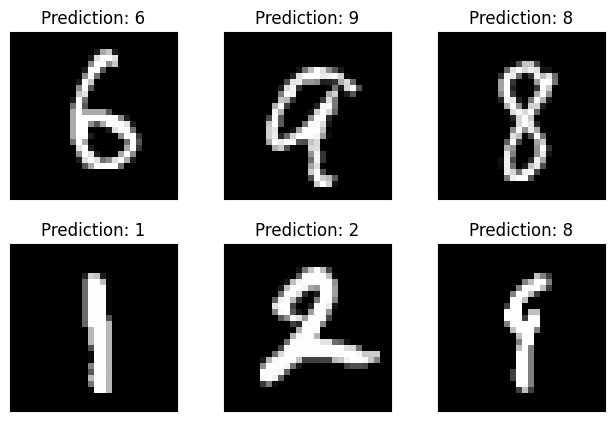

In [22]:

model.to("cpu")
testiter = iter(testloader)
images, labels = random.choice(list(testiter))

with torch.no_grad():
    output = model(images)

labels = output.data.max(1, keepdim=True)[1]

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(images[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    labels[i].item()))
  plt.xticks([])
  plt.yticks([])
